In [1]:
import keras
import pandas as pd
from keras import Sequential
from keras.layers import LSTM,Dense,Dropout, Embedding, Conv1D, MaxPooling1D, Flatten
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_imdb(path):
    from bs4 import BeautifulSoup
    import re, json
    import pandas as pd
    
    def preprocess(text):
        text = BeautifulSoup(text.lower(), "html5lib").text #removed html tags
        text = re.sub(r"[\W]+", " ", text)
        return text
    
    with open(path, "r", encoding="utf8") as f:
        comments = pd.DataFrame.from_dict([json.loads(l) for l in f])
        comments["content"] = comments["content"].apply(preprocess)
        return comments
        
comments = load_imdb("/data/imdb-comments.json")
comments.head()

,content,label,name,sentiment
0,i went and saw this movie last night after bei...,test,0_10.txt,pos
1,actor turned director bill paxton follows up h...,test,10000_7.txt,pos
2,as a recreational golfer with some knowledge o...,test,10001_9.txt,pos
3,i saw this film in a sneak preview and it is d...,test,10002_8.txt,pos
4,bill paxton has taken the true story of the 19...,test,10003_8.txt,pos


In [3]:
comments.sample(10)

,content,label,name,sentiment
26829,i can give you four reasons to see this movie ...,train,11647_8.txt,pos
47053,polyester was the very first john water s film...,train,7349_1.txt,neg
28994,i really enjoyed the first episode and am look...,train,2345_9.txt,pos
41945,i hate to even waste the time it takes to writ...,train,2751_1.txt,neg
33300,throughly enjoy all the musical numbers each t...,train,6220_8.txt,pos
40100,transylvania 6 5000 is an insignificant but o...,train,12340_4.txt,neg
8860,flowers if it s one thing you ll take away fro...,test,6725_8.txt,pos
47551,this review is based on the dubbed shock o ram...,train,7798_1.txt,neg
31818,this has just been broadcast on bbc and i am a...,train,4888_8.txt,pos
11625,wow this was a great movie i just got it from ...,test,9213_10.txt,pos


In [4]:
y = np.where(comments.sentiment == "pos", 1, 0)
is_training = comments.label == "train"

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments.content)
doc_terms = tokenizer.texts_to_sequences(comments.content)
len(doc_terms)

50000

In [6]:
comments.content[0]

'i went and saw this movie last night after being coaxed to by a few friends of mine i ll admit that i was reluctant to see it because from what i knew of ashton kutcher he was only able to do comedy i was wrong kutcher played the character of jake fischer very well and kevin costner played ben randall with such professionalism the sign of a good movie is that it can toy with our emotions this one did exactly that the entire theater which was sold out was overcome by laughter during the first half of the movie and were moved to tears during the second half while exiting the theater i not only saw many women in tears but many full grown men as well trying desperately not to let anyone see them crying this movie was great and i suggest that you go see it before you judge '

In [7]:
print(doc_terms[0])

[9, 416, 2, 210, 10, 15, 238, 311, 100, 109, 28203, 5, 33, 3, 173, 352, 4, 1758, 9, 232, 975, 11, 9, 13, 5735, 5, 65, 7, 84, 37, 47, 9, 672, 4, 9942, 9315, 24, 13, 62, 477, 5, 78, 201, 9, 13, 356, 9315, 254, 1, 104, 4, 3373, 15901, 53, 69, 2, 1621, 7132, 254, 1155, 8399, 17, 139, 11306, 1, 2016, 4, 3, 49, 15, 6, 11, 7, 50, 2970, 17, 258, 1334, 10, 28, 117, 619, 11, 1, 442, 764, 61, 13, 2986, 43, 13, 3232, 33, 2142, 303, 1, 88, 304, 4, 1, 15, 2, 71, 1649, 5, 1716, 303, 1, 338, 304, 136, 11778, 1, 764, 9, 23, 62, 210, 107, 362, 8, 1716, 18, 107, 364, 2061, 339, 14, 69, 264, 2816, 23, 5, 276, 246, 65, 92, 2488, 10, 15, 13, 80, 2, 9, 1466, 11, 20, 141, 65, 7, 161, 20, 1671]


In [12]:
str(tokenizer.word_docs)[:500]

"defaultdict(<class 'int'>, {'can': 19081, 'exactly': 1811, 'judge': 516, 'ashton': 49, 'character': 9551, 'night': 3415, 'see': 16263, 'in': 44006, 'after': 11359, 'what': 19837, 'but': 35787, 'anyone': 4749, 'not': 29780, 'and': 48298, 'jake': 158, 'only': 16467, 'from': 23240, 'laughter': 437, 'last': 4836, 'was': 32181, 'you': 27390, 'movie': 30562, 'women': 2531, 'second': 3352, 'moved': 619, 'saw': 5469, 'emotions': 749, 'before': 7146, 'entire': 2543, 'fischer': 21, 'costner': 58, 'many': "

In [13]:
words_by_index = dict([(i, word) for word, i in tokenizer.word_index.items()])

In [14]:
print([words_by_index[t] for t in doc_terms[0]])

['i', 'went', 'and', 'saw', 'this', 'movie', 'last', 'night', 'after', 'being', 'coaxed', 'to', 'by', 'a', 'few', 'friends', 'of', 'mine', 'i', 'll', 'admit', 'that', 'i', 'was', 'reluctant', 'to', 'see', 'it', 'because', 'from', 'what', 'i', 'knew', 'of', 'ashton', 'kutcher', 'he', 'was', 'only', 'able', 'to', 'do', 'comedy', 'i', 'was', 'wrong', 'kutcher', 'played', 'the', 'character', 'of', 'jake', 'fischer', 'very', 'well', 'and', 'kevin', 'costner', 'played', 'ben', 'randall', 'with', 'such', 'professionalism', 'the', 'sign', 'of', 'a', 'good', 'movie', 'is', 'that', 'it', 'can', 'toy', 'with', 'our', 'emotions', 'this', 'one', 'did', 'exactly', 'that', 'the', 'entire', 'theater', 'which', 'was', 'sold', 'out', 'was', 'overcome', 'by', 'laughter', 'during', 'the', 'first', 'half', 'of', 'the', 'movie', 'and', 'were', 'moved', 'to', 'tears', 'during', 'the', 'second', 'half', 'while', 'exiting', 'the', 'theater', 'i', 'not', 'only', 'saw', 'many', 'women', 'in', 'tears', 'but', 'ma

In [15]:
vocab_size = len(tokenizer.word_index)
vocab_size

103890

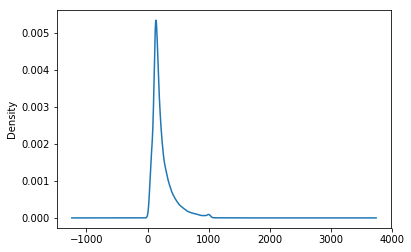

In [18]:
pd.Series([len(r) for r in doc_terms]).plot.kde()

In [24]:
maxlen = 250
doc_terms_padded = pad_sequences(doc_terms, padding="pre", maxlen=maxlen)
doc_terms_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     9,   416,
           2,   210,    10,    15,   238,   311,   100,   109, 28203,
           5,    33,     3,   173,   352,     4,  1758,     9,   232,
         975,    11,     9,    13,  5735,     5,    65,     7,    84,
          37,    47,

In [ ]:
tf.set_random_seed(1)
np.random.seed(1)

model = Sequential()
model.add(Embedding(maxlen + 1, 10, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='tanh'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(128, 3, activation='tanh'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(400, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(doc_terms_padded[is_training], y[is_training]
          , validation_data=(doc_terms_padded[~is_training], y[~is_training])
          , batch_size=64
          , epochs=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1000, 10)          10010     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000, 10)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 996, 64)           3264      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 249, 64)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 247, 128)          24704     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 61, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
__________